# Some testing

Load data

*Try replacing this with SelectFromModel*

In [7]:
import pandas as pd
import numpy as np
from preprocessing import clean_data, remove_missing, simple_clean

# Load df from csv
raw_data = pd.read_csv("data/train.csv")

#raw_data = raw_data.iloc[0:24]

# Clean data using function
#df_pre = drop_text(clean_data(raw_data))

#df = df_pre[['property_bedrooms', 'property_bathrooms', 'property_max_guests', 'target']]
df = remove_missing(clean_data(raw_data))
#df = simple_clean(raw_data)
#df.drop(['property_id'])

#df.head()
#df.shape

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into X and y
X, y = df.drop('target', axis=1), df['target']


# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model
xgb_model = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test)
preds_mean = np.array([y_test.mean()] * len(y_test))

# Calculate rmse
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
rmse_mean = np.sqrt(mean_squared_error(y_test, preds_mean))

print("RMSE: " + str(rmse))
print("RMSE mean: " + str(rmse_mean) + "\n")

#sns.scatterplot(x=preds, y=y_test)
print("Mean pred: " + str(xgb_preds.mean()) + ", Mean y: " + str(y_test.mean()))
print("SD pred: " + str(xgb_preds.std()) + ", SD y: " + str(y_test.std()))
print(y_train.mean(), y_test.mean())


RMSE: 62.17175253657733
RMSE mean: 56.48292728970687

Mean pred: 70.06475, Mean y: 67.76067527308838
SD pred: 25.526066, SD y: 56.51099334226603
67.59150732555253 67.76067527308838


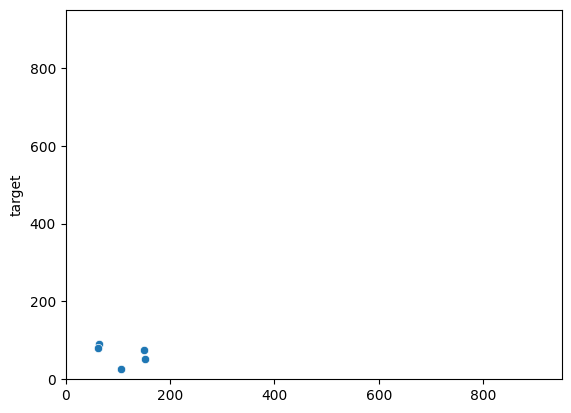

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

errors_xgb = y_test - xgb_preds
errors_mean = y_test - preds_mean

#sns.histplot(errors_xgb, kde=True, stat="density", color="green")
#sns.histplot(errors_mean, kde=True, stat="density", color="red")


#sns.histplot(xgb_preds, kde=True, stat="density", color="green")
#sns.histplot(y_test, kde=True, stat="density", color="red")
#sns.histplot(preds_mean, kde=True, stat="density", color="blue")

fig, ax = plt.subplots()
sns.scatterplot(x=xgb_preds, y=y_test, ax=ax)
ax.set_xlim(0, 950)
ax.set_ylim(0, 950)
plt.show()

# Random Forest

In [6]:
# Do random forest with sklearn
from sklearn.ensemble import RandomForestRegressor

# Create model
rf_model = RandomForestRegressor(n_estimators=50)
rf_model.fit(X_train, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test)
preds_mean = np.array([y_test.mean()] * len(y_test))

# Calculate rmse
rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rmse_mean = np.sqrt(mean_squared_error(y_test, preds_mean))

print(rmse)
print(rmse_mean)


54.80896058127721
23.004347415216976


<Axes: ylabel='target'>

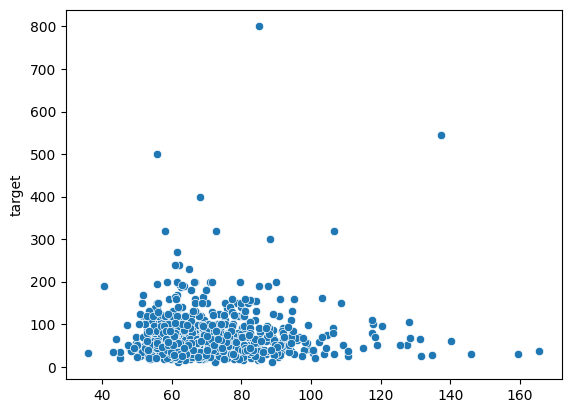

In [11]:
#sns.histplot(rf_preds, kde=True, stat="density", color="green")
#sns.histplot(y_test, kde=True, stat="density", color="red")

sns.scatterplot(x=rf_preds, y=y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

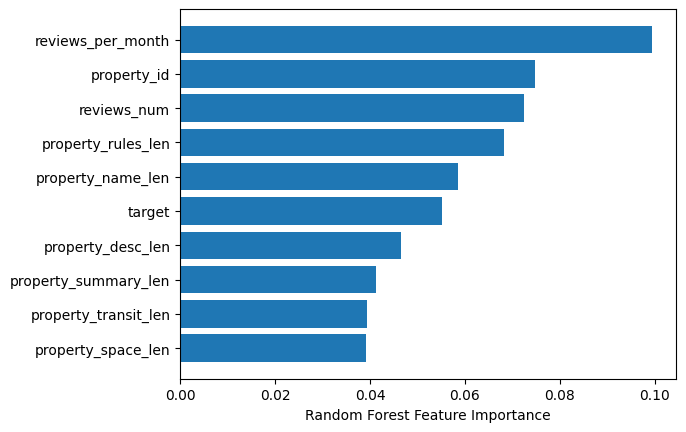

In [218]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Compute feature importances of random forest model
rf_model.feature_importances_

sorted_idx = rf_model.feature_importances_.argsort()
#plt.barh(df.columns[sorted_idx], model.feature_importances_[sorted_idx])
#plt.xlabel("Random Forest Feature Importance")

# Plot only the 10 highest feature importances
plt.barh(df.columns[sorted_idx][-10:], rf_model.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")

# Plot feature importances
(Probably not right method, fix this)

None


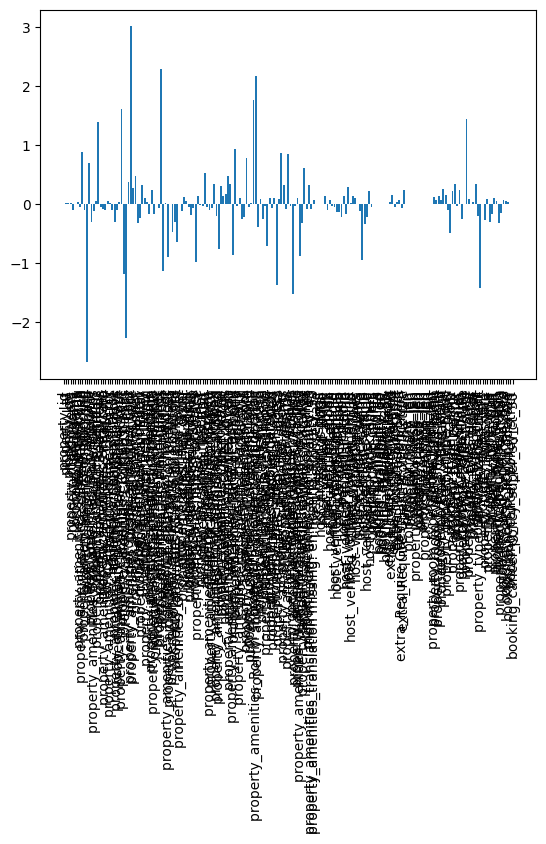

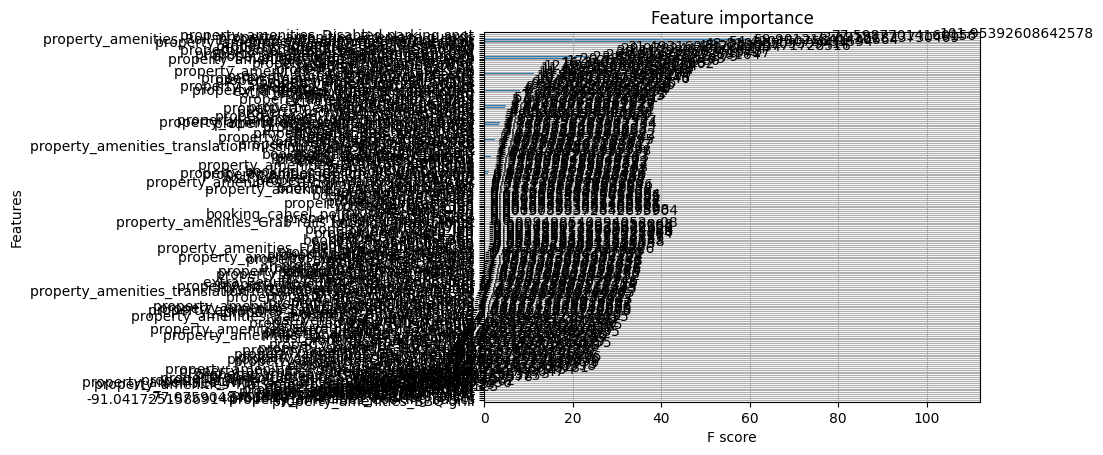

In [101]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

print(xgb_model.importance_type)

# Plot feature importances
plt.bar(X.columns, xgb_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()


# Using xgboost built-in function
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

Text(0.5, 0, 'Permutation Importance')

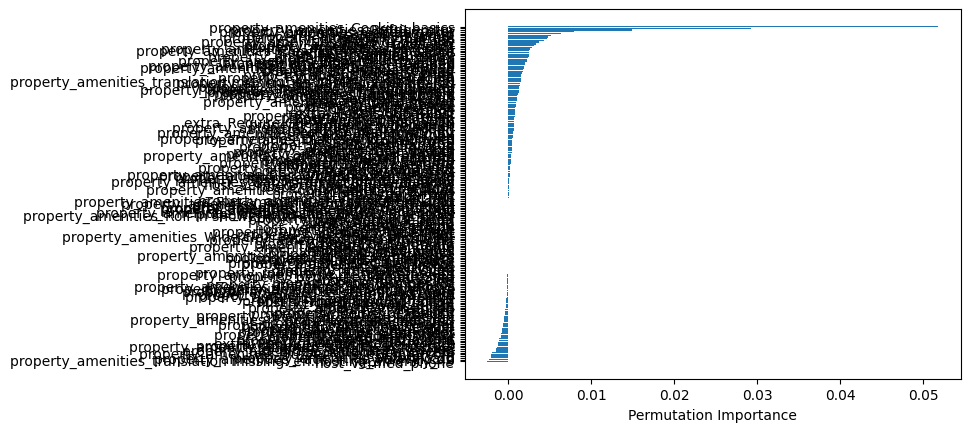

In [102]:
perm_importance = permutation_importance(xgb_model, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
